Loading tokenizer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model...


/root/anaconda3/envs/caption/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/root/anaconda3/envs/caption/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Model loaded successfully!


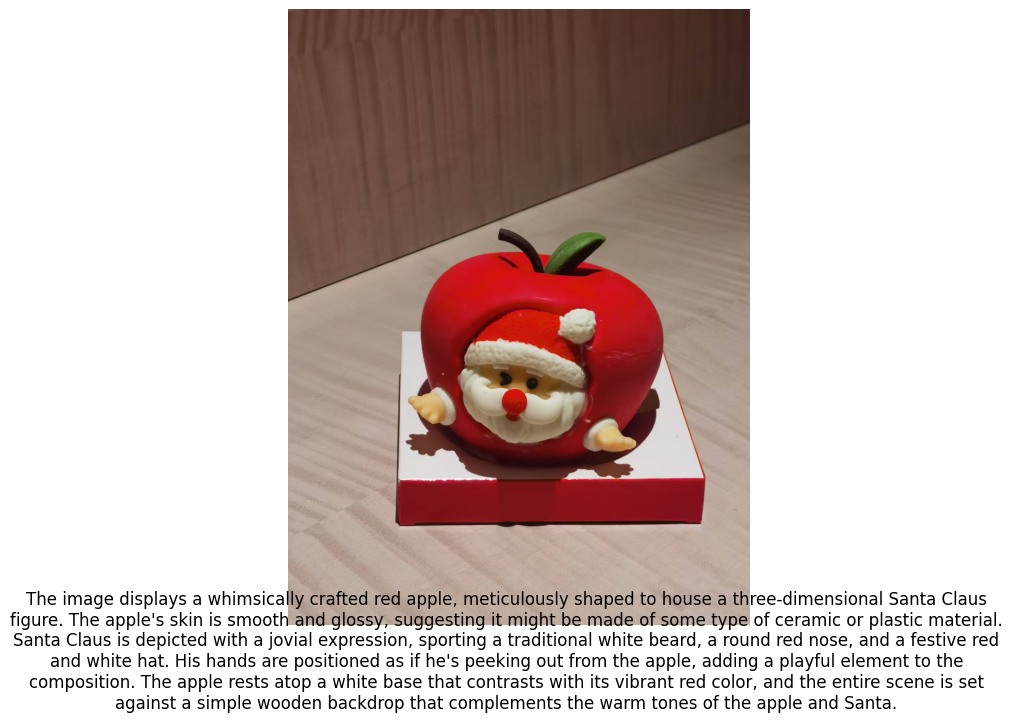

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from textwrap import fill
from matplotlib.patches import Rectangle
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM


os.environ["TRANSFORMERS_OFFLINE"] = "1"

MODEL_PATH = "/opt/data/private/hhc/workdir/CogVLM2/model"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TORCH_TYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[
    0] >= 8 else torch.float16



print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=TORCH_TYPE, trust_remote_code=True, low_cpu_mem_usage=True).eval()
print("Model loaded successfully!")

image_path = "/opt/data/private/hhc/workdir/CogVLM2/haichen/santa.jpg"
image = Image.open(image_path).convert('RGB')

# query = input("Human:")
query = "In one sentence, describe this image in detail. Start with 'The image shows'"
# query = 'In one sentence, describe content that is visible in the image. Prioritize accuracy. Start with "the image shows"'
history = []

input_by_model = model.build_conversation_input_ids(
                tokenizer,
                query=query,
                history=history,
                images=[image],
                template_version='chat'
            )

inputs = {
            'input_ids': input_by_model['input_ids'].unsqueeze(0).to(DEVICE),
            'token_type_ids': input_by_model['token_type_ids'].unsqueeze(0).to(DEVICE),
            'attention_mask': input_by_model['attention_mask'].unsqueeze(0).to(DEVICE),
            'images': [[input_by_model['images'][0].to(DEVICE).to(TORCH_TYPE)]] if image is not None else None,
        }

gen_kwargs = {
            "max_new_tokens": 1024,
            "pad_token_id": 128002,
        }

with torch.no_grad():
        outputs = model.generate(**inputs, **gen_kwargs)
        outputs = outputs[:, inputs['input_ids'].shape[1]:]
        response = tokenizer.decode(outputs[0])
        response = response.split("<|end_of_text|>")[0]
        # print("\nCogVLM2:", response)

# 创建一个 Matplotlib 图形
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")  # 关闭坐标轴

# 在图片下方显示文字
plt.figtext(0.5, 0.01, response, wrap=True, horizontalalignment="center", fontsize=12)

# 显示图片
plt.show()